# 5. Automatic Differentiation

My learning noteSbook following the live lesson series "Calculus for Machine Learning" by Dr. Jon Krohn. I adapted parts of the source code provided in the lecture, wrote some additional features to better understand Calculus. 
Learning notes and code largely based on the lesson's source code. For the original, please see: 
- https://learning.oreilly.com/videos/calculus-for-machine/9780137398171/
- https://github.com/jonkrohn/ML-foundations/blob/master/notebooks/regression-in-pytorch.ipynb

<br />

Autodiff/autograd
- Computational diff.
- Reverse mode diff.
- Algorithmic  diff.

Distinct from classical methods:
- Numerical diff. (delta method; introduces rounding errors)
- Symbolic diff. (algebraic rules; computationally inefficiant)

Relativei to classical methods, better handles:
- Functions with many inputs (which is common in ML)
- Higher-order derivatives

In [110]:
import torch
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow


## 5.1 Introduction
- Application of chain rule (typically to partial derivative) to sequence ($\text{forward pass} of arithmetic operations  

Differences
- Chain rule by hand typically begins at most-nested function. 
- Autodiff proceeds from outermost function inward. 
- Small constant factor more compute than forward pass (at most)

<br />

**$Gradient$**  
an increase or decrease in the magnitude of a property (e.g. temperature, pressure, or concentration) observed in passing from one point or moment to another.

## 5.2 Autodiff with PyTorch

TensorFlow and PyTorch are the two most popular automatic differentiation libraries.

Let's use them to calculate $\frac{dy}{dx}$ at $x = 5$ where:

$$y = x^2$$
$$ \frac{dy}{dx} = 2x = 2(5) = 10 $$


### PyTorch functions
- ```x.requires_grad_()```
- ```y.backward()```
- ```x.grad()```

In [111]:
x = torch.tensor(5.0)   # create a float tensor
x

tensor(5.)

In [112]:
x.requires_grad_() # contagiously track gradients through forward pass

tensor(5., requires_grad=True)

In [113]:
y = x**2

In [114]:
y.backward() # use autodiff

In [115]:
x.grad

tensor(10.)

## 5.3 Autodiff with TensorFlow



In [116]:
x = tf.Variable(5.0)

In [117]:
with tf.GradientTape() as t:  # track gradient
  t.watch(x)                  # declare the variable to watch - track forward pass
  y = x**2                    # define the pass

In [118]:
t.gradient(y, x)  # use autodiff

<tf.Tensor: shape=(), dtype=float32, numpy=10.0>

## 5.4 Directed Acyclic Graph of a Line Equation
$$y=mx+b$$
- $m$ = $m_{tan}$, slope
- $b$ = bias

<br />

Nodes are input, output, parameters or operations.
Directed edges ("arrows") are tensors.


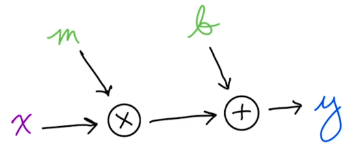

In [ ]:
path = "/content/line_equation.png"
eq = cv2.imread(path)
eq = cv2.resize(eq, dsize=(0,0), fx=0.65, fy=0.65)
cv2_imshow(eq)

# lecture slide from 5.4 Directed Acyclic Graph of a Line Equation by Dr. Krohn

### Regression in PyTorch
Here we use calculus to solve the same regression problem that we used the Moore-Penrose Pseudoinverse

In [119]:
x = torch.tensor(np.arange(0, 8))   # E.g.: Dosage of drug for treating Alzheimer's disease
x

tensor([0, 1, 2, 3, 4, 5, 6, 7])

The $y$ values were created using the equation of a line $y = mx + b$. This way, we know what the model parameters to be learned are, say, $m = -0.5$ and $b = 2$. $\text{Random, normally-distributed noise}$ has been added to simulate sampling error:

In [ ]:
# y = -0.5*x + 2 + torch.normal(mean=torch.zeros(8), std=0.2)

In [120]:
y = torch.tensor([1.86, 1.31, .62, .33, .09, -.67, -1.23, -1.37]) # E.g.: Patient's "forgetfulness score"
y

tensor([ 1.8600,  1.3100,  0.6200,  0.3300,  0.0900, -0.6700, -1.2300, -1.3700])

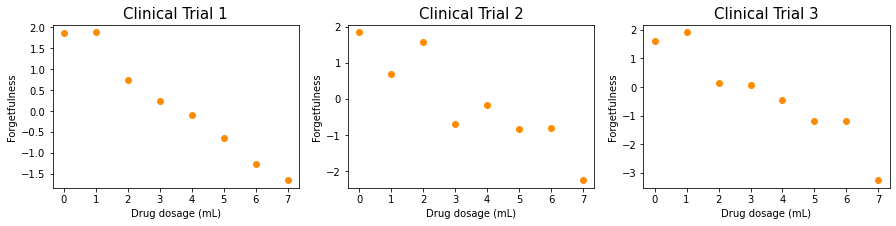

In [ ]:
std = [0.2, 0.5, 1]
ys = []

fig, ax = plt.subplots(1, 3, figsize=(15, 3))
for i in range(3):
  y = -0.5*x + 2 + torch.normal(mean=torch.zeros(8), std=std[i])
  ys.append(y)
  ax[i].set_xlabel("Drug dosage (mL)")
  ax[i].set_ylabel("Forgetfulness")
  ax[i].scatter(x, y, c='darkorange')
  ax[i].set_title(f"Clinical Trial {i+1}", fontsize=15)

Initialize the slope parameter $m$ with a "random" value of 0.9...

(N.B.: In this simple demo, we could guess approximately-correct parameter values to start with. Or, we could use an algebraic (e.g., Moore-Penrose pseudoinverse) or statistical (e.g., ordinary-least-squares regression) to solve for the parameters quickly. This tiny machine learning demo with two parameters and eight data points scales, however, to millions of parameters and millions of data points. The other approaches -- guessing, algebra, statistics -- do not come close to scaling in this way.)

In [ ]:
x = torch.tensor(np.arange(0,8))
m = torch.tensor([0.9]).requires_grad_()
b = torch.tensor([0.1]).requires_grad_()

x, m, b

(tensor([0, 1, 2, 3, 4, 5, 6, 7]),
 tensor([0.9000], requires_grad=True),
 tensor([0.1000], requires_grad=True))

In [123]:
def regression(x, m, b):
  return m*x + b

In [180]:
def regression_plot(x, y, m, b):
    
    fig, ax = plt.subplots()

    ax.scatter(x, y)
    
    x_min, x_max = ax.get_xlim()
    y_min = regression(x_min, m, b)
    y_max = regression(x_max, m, b)
    
    ax.set_xlim([x_min, x_max])
    _ = ax.plot([x_min, x_max], [y_min, y_max])

Observation. As the value of standard deviation increases, the data points fluctuates and the linearity gradually get lost.

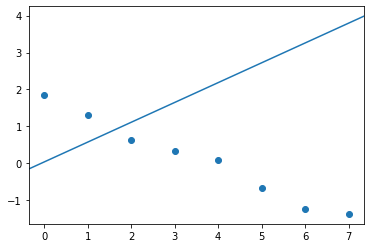

In [ ]:
regression_plot(x, y, m, b)

## 5.5 Fitting a Line with Machine Learning

When performing regression, we compare the prediction value $\hat y$ to the ground truth $y$. This comparison is performed by means of "$\text{lost function}$ (or $\text{cost function}$). 

- Prediction: $\hat y = f(x, m, b)$
- Cost function: $C = g(\hat y, y)$
- $C = g(f(x, m, b), y)$

<br/>

**ML Regression Process**  
1) Forward pass  
2) Compare $\hat y$ with true $y$ to calculate cost $C$.   
3) Chain rule comes in handy here: it calculates the gradient of $C$ with respect to $parameters$.  
4) Ajust to $m$ and $b$ to reduce $C$.

### **Step 1. Forward Pass**

In [ ]:
# produce prediction values for each input x value. 
y_hat = regression(x, m, b)
y_hat

tensor([0.1000, 1.0000, 1.9000, 2.8000, 3.7000, 4.6000, 5.5000, 6.4000],
       grad_fn=<AddBackward0>)

As shown in the graph right above, the first prediction set will be no way near the ground truth. This is because b m is initiated at a random value just to start the regression process.

So how do we evaluate the difference? The typical and best solution is MSE cost. 

$$C = \frac{1}{n} \sum_{i=1}^n (\hat{y_i}-y_i)^2 $$
(Sum of all squared differences between the prediction and the truth.)

Why square?
- All resulting values will be positive $\rightarrow$ easier to compare values.
- Squaring $\text{exponentially penalises}$ the differences between values; and relatively tolerant to relatively smaller differences.

### Step 2. Compare $\hat y$  with true $y$ to calculate cost $C$.

In [ ]:
def mse(y_hat, y):
  sigma = torch.sum((y_hat - y)**2)
  return sigma/len(y)

In [ ]:
C = mse(y_hat, y)
C

tensor(19.6755, grad_fn=<DivBackward0>)

tensor([0.1000, 1.0000, 1.9000, 2.8000, 3.7000, 4.6000, 5.5000, 6.4000],
       grad_fn=<AddBackward0>)
tensor([ 1.8600,  1.3100,  0.6200,  0.3300,  0.0900, -0.6700, -1.2300, -1.3700])


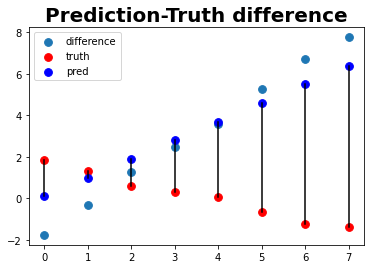

In [ ]:
print(y_hat)
print(y)
def see_difference(y_hat, y):
    y = y.detach().numpy()
    y_hat = y_hat.detach().numpy()
    diff = y_hat - y
    fig, ax = plt.subplots()
    ax.scatter(x, diff, s=60, label='difference')
    ax.scatter(x, y, c='red', s=60, label="truth")
    ax.scatter(x, y_hat, c='blue', s=60, label="pred")
    for i in range(len(y)):
      ax.plot([x[i], x[i]],[y_hat[i], y[i]],'k-')
    ax.legend()
    plt.title("Prediction-Truth difference", fontsize=20, fontweight='bold')

see_difference(y_hat, y)

### Step 3. Use autodiff to calculate gradient of $C$ with respect to parameters.

"We perform automatic differentiation backward from that end point, and because we're tracking gradients on both M and B, we can obtain what the slope of C is with respect to both M and B, given all of the inputs that we have right now, into our model." ([5.4 Directed Acyclic Graph](https://learning.oreilly.com/videos/calculus-for-machine/9780137398171/))*

- a gradient is a derivative of a function that has more than one input variable.
- $gradient$ = $derivative$

In [ ]:
C.backward()

In [ ]:
m.grad

tensor([36.3050])

In [ ]:
b.grad

tensor([6.2650])

### Step 4. Gradient Descent 

In [ ]:
optimizer = torch.optim.SGD([m, b], lr=0.01)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0
    nesterov: False
    weight_decay: 0
)

Gradient descent allows up to take a step with $m$ and $b$ values to adjust $m$ and $b$ in the direction, the gradient tells us, will reduce cost. 

In [ ]:
optimizer.step()

In [ ]:
m

tensor([0.5369], requires_grad=True)

In [ ]:
b

tensor([0.0374], requires_grad=True)

Seemingly, the graph below looks hardly different from the first graph above. This is because we set the learning rate to a minuscule difference (0.1), but the slope is adjusted.

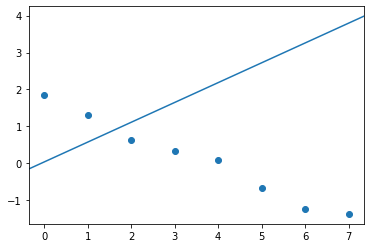

In [ ]:
regression_plot(x, y, m, b)

### Repeat Steps 1. and 2.

In [ ]:
# Steps 1 and 2 in one basket.

C = mse(regression(x, m, b), y)
C

tensor(8.5722, grad_fn=<DivBackward0>)

### Iteration - Loop through the 4 steps
in order to iteratively minimise the cose towards zero.

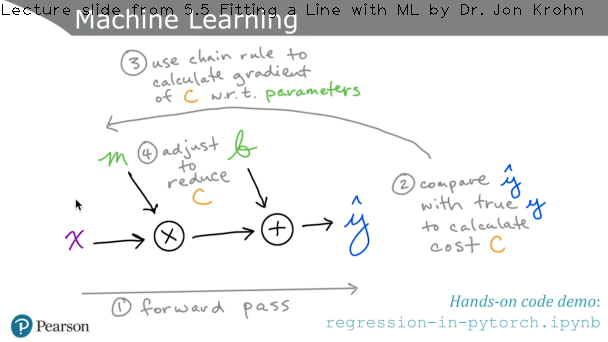

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
path = "/content/ml process.png"
ml_process = cv2.imread(path)
ml_process = cv2.resize(ml_process, dsize=(0,0), fx=0.5, fy=0.5)
ml_process = cv2.putText(ml_process, "Lecture slide from 5.5 Fitting a Line with ML by Dr. Jon Krohn", 
                         org=(0, 15), fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=1.1, color=1, thickness=1)
cv2_imshow(ml_process)

In [192]:
# Compare with the above diagram.

x = torch.tensor(np.arange(0, 8))
y = torch.tensor([1.86, 1.31, .62, .33, .09, -.67, -1.23, -1.37])

m = torch.tensor([0.9]).requires_grad_()
b = torch.tensor([0.1]).requires_grad_()
y_hat = regression(x, m, b)

optimisation = []
epochs = 1000

optimizer = torch.optim.SGD([m, b], lr=0.01)
weights_biases = []

def regression(x, m, b):
  return m*x + b

def mse(y_hat, y):
  sigma = torch.sum((y_hat - y)**2)
  return sigma/len(y)

for epoch in range(epochs):

  optimizer.zero_grad()   # Reset gradients to zero; else they accumulate, occupying memory resource for values that need not be stored.

  y_hat = regression(x, m, b)   # step 1: calculate the difference between prediction and truth.
  C = mse(y_hat, y)             # step 2: calculate the cost.
  C.backward()                  # step 3: backpropagate.
  optimizer.step()              # step 4: Get gradient descent at set learning rate.

  opt = [epoch, C.item(), m.grad.item(), b.grad.item()]
  optimisation.append(opt)

  m_b = [m.item(), b.item()]
  weights_biases.append(m_b)

  print('Epoch {}, cost {}, m grad {}, b grad {}'.format(epoch, '%.3g' % C.item(), '%.3g' % m.grad.item(), '%.3g' % b.grad.item()))

Epoch 0, cost 19.7, m grad 36.3, b grad 6.26
Epoch 1, cost 8.57, m grad 23.2, b grad 3.6
Epoch 2, cost 4.08, m grad 14.8, b grad 1.91
Epoch 3, cost 2.25, m grad 9.49, b grad 0.831
Epoch 4, cost 1.51, m grad 6.11, b grad 0.15
Epoch 5, cost 1.2, m grad 3.96, b grad -0.28
Epoch 6, cost 1.07, m grad 2.59, b grad -0.552
Epoch 7, cost 1.01, m grad 1.72, b grad -0.723
Epoch 8, cost 0.981, m grad 1.17, b grad -0.829
Epoch 9, cost 0.962, m grad 0.82, b grad -0.894
Epoch 10, cost 0.948, m grad 0.595, b grad -0.934
Epoch 11, cost 0.936, m grad 0.452, b grad -0.957
Epoch 12, cost 0.925, m grad 0.361, b grad -0.969
Epoch 13, cost 0.915, m grad 0.302, b grad -0.975
Epoch 14, cost 0.904, m grad 0.265, b grad -0.977
Epoch 15, cost 0.894, m grad 0.241, b grad -0.976
Epoch 16, cost 0.884, m grad 0.225, b grad -0.973
Epoch 17, cost 0.874, m grad 0.214, b grad -0.969
Epoch 18, cost 0.864, m grad 0.207, b grad -0.965
Epoch 19, cost 0.854, m grad 0.202, b grad -0.96
Epoch 20, cost 0.845, m grad 0.199, b gra

## N.6 Evaluation

Initially, we started off with $m = -0.5$ for slope, and $b=2$ for bias.  
Check it out at the section **Regression in PyTorch** ;)
Compare these initial values with the below $\text{optimised}$ $m$ and $b$.

In [202]:
m.item()

-0.4681191146373749

In [203]:
b.item()

1.754263162612915

Let's plot some graphs to see the achievement of gradient descent and the changing behaviour through the optimisation process.

In [193]:
costs = [optimisation[1] for optimisation in optimisation]
weights = [optimisation[2] for optimisation in optimisation]
biases = [optimisation[3] for optimisation in optimisation]

# values from epoch 2 are corrupted for some reason.
# Correcting the values manually.
costs[1] = 8.57
weights[1] = 23.2
biases[1] = 3.6

print(costs[:10])
print(weights[:10])
print(biases[:10])

[19.675472259521484, 8.57, 4.077259063720703, 2.2535147666931152, 1.509533405303955, 1.2020677328109741, 1.0711182355880737, 1.0115931034088135, 0.9810133576393127, 0.9622082114219666]
[36.304996490478516, 23.2, 14.801920890808105, 9.487884521484375, 6.108957290649414, 3.9603090286254883, 2.5938315391540527, 1.7246336936950684, 1.1715922355651855, 0.8195546865463257]
[6.2649993896484375, 3.6, 1.905204176902771, 0.8309656381607056, 0.15019437670707703, -0.280436635017395, -0.5520493984222412, -0.7225766181945801, -0.8288494348526001, -0.8942838907241821]


Text(0.5, 1.0, 'Optimising Regression with Gradient Descent')

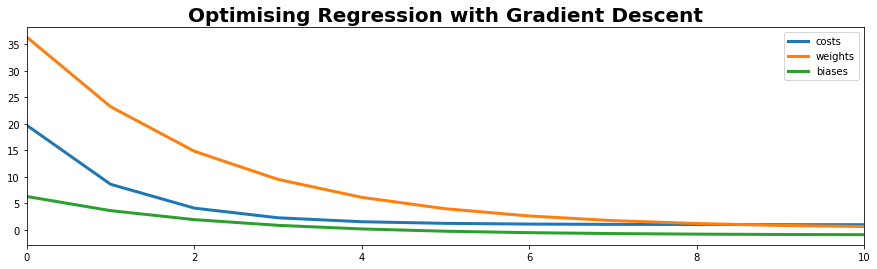

In [196]:
fig, ax = plt.subplots(figsize=(15, 4))

epoch = np.arange(1000)
parameters = [costs, weights, biases]
labels = ["costs", "weights", "biases"]

for i in range(3):
  ax.plot(epoch, parameters[i], label=labels[i], linewidth=3)
  ax.set_xlim(0, 10)
  ax.legend()
plt.title("Optimising Regression with Gradient Descent", fontsize=20, fontweight='bold', fontname='Helvetica')

In [191]:
m.item()

-0.4681191146373749

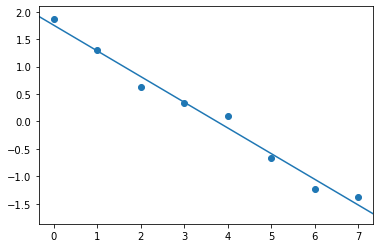

In [182]:
# Optimisation final result
x = torch.tensor(np.arange(0, 8))
regression_plot(x, y, m, b)

See how fitting the line transitioned from the far-from-good predictions to can't-be-tighter fit. 

epoch 99   weight: -0.2569701075553894   bias: 0.7159093022346497
epoch 199   weight: -0.35019880533218384   bias: 1.174373984336853
epoch 299   weight: -0.40249040722846985   bias: 1.4315249919891357
epoch 399   weight: -0.43182042241096497   bias: 1.5757592916488647
epoch 499   weight: -0.4482715427875519   bias: 1.6566598415374756
epoch 599   weight: -0.4574989080429077   bias: 1.7020368576049805
epoch 699   weight: -0.46267449855804443   bias: 1.7274885177612305
epoch 799   weight: -0.46557745337486267   bias: 1.7417640686035156
epoch 899   weight: -0.4672057330608368   bias: 1.7497713565826416
epoch 999   weight: -0.4681191146373749   bias: 1.754263162612915


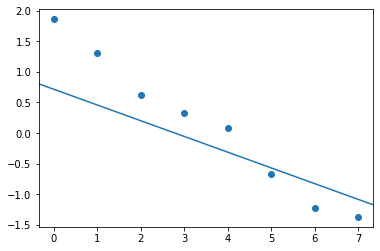

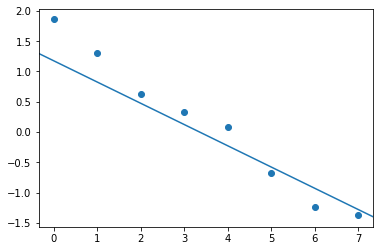

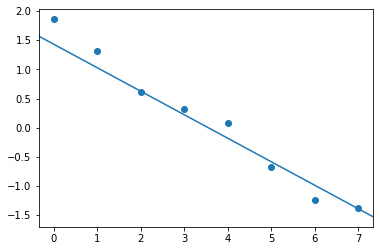

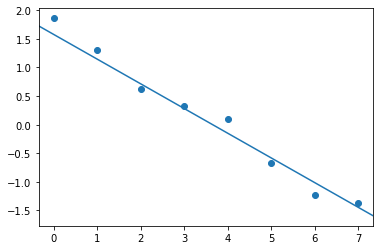

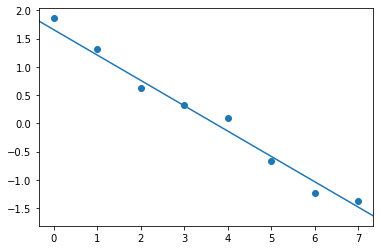

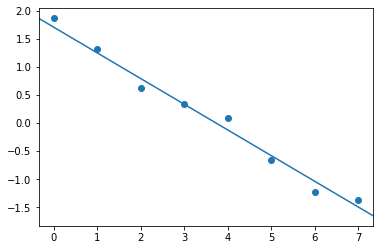

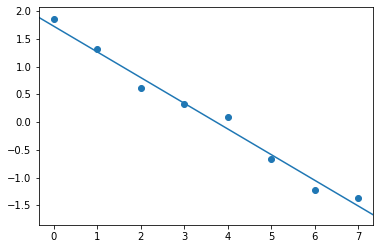

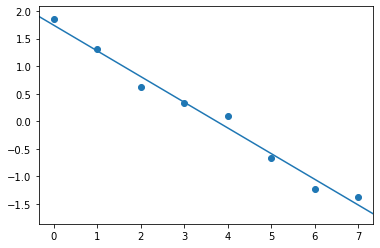

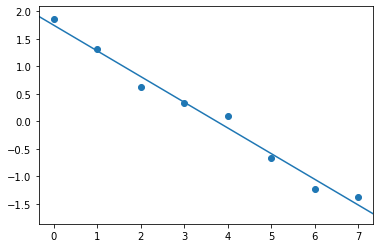

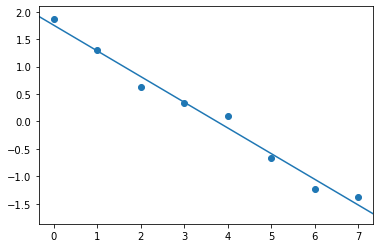

In [200]:
x = torch.tensor(np.arange(0, 8))
y = torch.tensor([1.86, 1.31, .62, .33, .09, -.67, -1.23, -1.37])

weights = [weight[0] for weight in weights_biases]
biases = [biases[1] for biases in weights_biases]

for i in range(1, 11):
    regression_plot(x, y, weights[i*100-1], biases[i*100-1])
    print(f'epoch {i*100-1}   weight: {weights[i*100-1]}   bias: {biases[i*100-1]}')

See the optimisation process in a single graph.

Text(0.5, 1.0, 'Gradual optimisation\nover 1000 epochs')

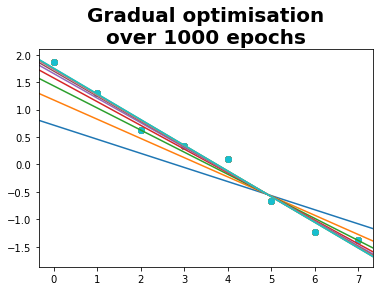

In [207]:
x = torch.tensor(np.arange(0, 8))
y = torch.tensor([1.86, 1.31, .62, .33, .09, -.67, -1.23, -1.37])

weights = [weight[0] for weight in weights_biases]
biases = [biases[1] for biases in weights_biases]

fig, ax = plt.subplots()
for i in range(1, 11):
  ax.scatter(x, y)
  
  x_min, x_max = ax.get_xlim()
  y_min = regression(x_min, weights[i*100-1], biases[i*100-1])
  y_max = regression(x_max, weights[i*100-1], biases[i*100-1])
  
  ax.set_xlim([x_min, x_max])
  _ = ax.plot([x_min, x_max], [y_min, y_max])

plt.title("Gradual optimisation\nover 1000 epochs", fontsize=20, fontweight='bold')

## Further learning

### Exercise 1
Use PyTorch (or TensorFlow) to find the slope of $$y = x^2 + 2x+2$$ where $x=2$.

### Exercise 2
Use the $Regression$ in PyTorch notebook to simulate a new linear relationshpi between $y$ and $x$, and then fit the parameters $m$ and $b$.

### Exercise 3
Read about how $\text{differential programming}$, wherein computer programs can be differentiated, could be common soon.
- https://tryolabs.com/blog/2020/04/02/swift-googles-bet-on-differentiable-programming/

### loss.backward() 
```loss.backward()``` computes $\frac{\delta loss}{\delta x}$ for every parameter $x$ which has ```requires_grad=True```. These are accumulated into ```x.grad``` for every parameter $x$ ([Colsbury](https://discuss.pytorch.org/t/what-does-the-backward-function-do/9944)).

# New Functions
- Plotting lines connecting points
  - ```plt.plot([x1,x2],[y1,y2],'k-')```  
  https://stackoverflow.com/questions/35363444/plotting-lines-connecting-points
- Put text on image  
  - ```cv2.putText()```  
  https://www.geeksforgeeks.org/python-opencv-cv2-puttext-method/
- Line style - thickness
  - ```plt.plot(linewidth=n)```
  https://pythoninformer.com/python-libraries/matplotlib/line-plots/

# Error Notes

    RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

The tensor (x) was created with a condition attached (```requires_grad_()```), so we need to detach it, so convert it into np.array. 

https://stackoverflow.com/questions/55466298/pytorch-cant-call-numpy-on-variable-that-requires-grad-use-var-detach-num

https://github.com/jonkrohn/ML-foundations/blob/master/notebooks/regression-in-pytorch.ipynb